# Word2Vec NN

In [1]:
FILE_NAME = "fasttext_nn"
TITLE = "Fasttext_RNN"

In [2]:
from utils.load_data import get_data, load_parquet_data

size = 's'

X_train, X_test, y_train, y_test = get_data(size)
print([X_train.shape, X_test.shape, y_train.shape, y_test.shape])


[(128000,), (32000,), (128000,), (32000,)]


## Fit Model

In [3]:
from gensim.models import FastText

model_fasttext = FastText.load("./output/fastText.model")


In [4]:
import tensorflow as tf
import polars as pl
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, GRU
from keras.layers import Embedding
# from utils.word2vec import get_embedding_layer, GensimEmbedding

2023-03-27 01:02:32.791846: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-27 01:02:33.472683: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.7/lib64
2023-03-27 01:02:33.472758: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.7/lib64
2023-03-27 01:02:33.472764: W tensorflow/compiler/tf2tensorrt/utils/py_utils

In [5]:
def get_embedding_layer(model):
    embedding_matrix = np.zeros((len(model.wv.index_to_key) + 1, model.vector_size))
    word2idx = {}

    vocab_list = [(word, model.wv[word]) for word in model.wv.index_to_key]
    for i, vocab in enumerate(vocab_list):
        word, vec = vocab
        embedding_matrix[i + 1] = vec
        word2idx[word] = i + 1

    embedding_layer = Embedding(
        input_dim=embedding_matrix.shape[0],
        output_dim=embedding_matrix.shape[1],
        weights=[embedding_matrix],
        trainable=False,
    )

    return embedding_layer


In [6]:
from keras.utils import pad_sequences

def process(texts):
    PADDING_LENGTH = 128
    supported_words = set(model_fasttext.wv.index_to_key)

    text_index = [[model_fasttext.wv.key_to_index[word] if word in supported_words else 0 for word in sentence] for sentence in texts]
    text_index = pad_sequences(text_index, maxlen=PADDING_LENGTH)
    return np.array(text_index)


In [7]:
import time
id = time.strftime('%H%M%S')

rnn = Sequential(name=f"{TITLE}_{id}")
rnn.add(get_embedding_layer(model_fasttext))
rnn.add(GRU(256, dropout=0.3, return_sequences=True))
rnn.add(GRU(128, dropout=0.3, return_sequences=True))
rnn.add(GRU(64, dropout=0.3, return_sequences=True))
rnn.add(GRU(32))
rnn.add(Dense(32, activation="relu"))
rnn.add(Dense(16, activation="relu"))
rnn.add(Dense(1, activation="sigmoid"))

# rnn.build((1,))
rnn.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
rnn.summary()


2023-03-27 01:02:34.094886: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-27 01:02:34.115626: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-27 01:02:34.115859: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-27 01:02:34.116537: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, 

Model: "Fasttext_RNN_010233"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 500)         21182500  
                                                                 
 gru (GRU)                   (None, None, 256)         582144    
                                                                 
 gru_1 (GRU)                 (None, None, 128)         148224    
                                                                 
 gru_2 (GRU)                 (None, None, 64)          37248     
                                                                 
 gru_3 (GRU)                 (None, 32)                9408      
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 
 dense_1 (Dense)             (None, 16)        

In [8]:
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
ckpt = tf.keras.callbacks.ModelCheckpoint(f'./output/model_nn/{FILE_NAME}_{id}_{size}_model.h5', monitor='val_loss', save_best_only=True, mode='auto')
board = tf.keras.callbacks.TensorBoard(log_dir=f"./output/model_nn/logs/{FILE_NAME}_{id}/", histogram_freq=1, embeddings_freq=1)

callbacks = [earlyStopping, ckpt, board]

In [9]:
X_train_processed = process(X_train)
X_test_processed = process(X_test)
y_train_processed = np.where(y_train == 'true', 1, 0)
y_test_processed = np.where(y_test == 'true', 1, 0)

In [10]:
result = rnn.fit(x=X_train_processed, y=y_train_processed, batch_size=250, epochs=10000, validation_split=0.4, callbacks=callbacks)


Epoch 1/10000


2023-03-27 01:02:42.489243: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8801
2023-03-27 01:02:42.657739: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-03-27 01:02:42.678197: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fb87a8fde80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-27 01:02:42.678239: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2023-03-27 01:02:42.681556: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-03-27 01:02:42.878193: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of 

307/308 [============================>.] - ETA: 0s - loss: 0.6475 - accuracy: 0.6040

2023-03-27 01:03:01.088849: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 5083800000 exceeds 10% of free system memory.


308/308 [==============================] - 24s 60ms/step - loss: 0.6474 - accuracy: 0.6042 - val_loss: 0.5471 - val_accuracy: 0.7229
Epoch 2/10000
308/308 [==============================] - ETA: 0s - loss: 0.4762 - accuracy: 0.7747

2023-03-27 01:03:18.541902: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 5083800000 exceeds 10% of free system memory.


308/308 [==============================] - 18s 59ms/step - loss: 0.4762 - accuracy: 0.7747 - val_loss: 0.4094 - val_accuracy: 0.8166
Epoch 3/10000
308/308 [==============================] - ETA: 0s - loss: 0.3840 - accuracy: 0.8297

2023-03-27 01:03:37.208365: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 5083800000 exceeds 10% of free system memory.


308/308 [==============================] - 19s 63ms/step - loss: 0.3840 - accuracy: 0.8297 - val_loss: 0.3609 - val_accuracy: 0.8418
Epoch 4/10000
307/308 [============================>.] - ETA: 0s - loss: 0.3328 - accuracy: 0.8575

2023-03-27 01:03:56.991500: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 5083800000 exceeds 10% of free system memory.


308/308 [==============================] - 19s 63ms/step - loss: 0.3328 - accuracy: 0.8575 - val_loss: 0.3269 - val_accuracy: 0.8604
Epoch 5/10000
307/308 [============================>.] - ETA: 0s - loss: 0.2967 - accuracy: 0.8750

2023-03-27 01:04:17.435416: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 5083800000 exceeds 10% of free system memory.


308/308 [==============================] - 20s 66ms/step - loss: 0.2967 - accuracy: 0.8751 - val_loss: 0.3137 - val_accuracy: 0.8684
Epoch 6/10000
308/308 [==============================] - 21s 69ms/step - loss: 0.2673 - accuracy: 0.8892 - val_loss: 0.3055 - val_accuracy: 0.8749
Epoch 7/10000
308/308 [==============================] - 21s 67ms/step - loss: 0.2445 - accuracy: 0.9015 - val_loss: 0.2900 - val_accuracy: 0.8836
Epoch 8/10000
308/308 [==============================] - 22s 70ms/step - loss: 0.2231 - accuracy: 0.9105 - val_loss: 0.2904 - val_accuracy: 0.8875
Epoch 9/10000
308/308 [==============================] - 21s 67ms/step - loss: 0.2063 - accuracy: 0.9179 - val_loss: 0.3122 - val_accuracy: 0.8853
Epoch 10/10000
308/308 [==============================] - 19s 61ms/step - loss: 0.1920 - accuracy: 0.9235 - val_loss: 0.2959 - val_accuracy: 0.8864


In [11]:
results = rnn.evaluate(X_test_processed, y_test_processed, batch_size=3000, return_dict=True)
print("Testing", results)

11/11 [==============================] - 1s 72ms/step - loss: 0.2958 - accuracy: 0.8860
Testing {'loss': 0.29575449228286743, 'accuracy': 0.8859687447547913}


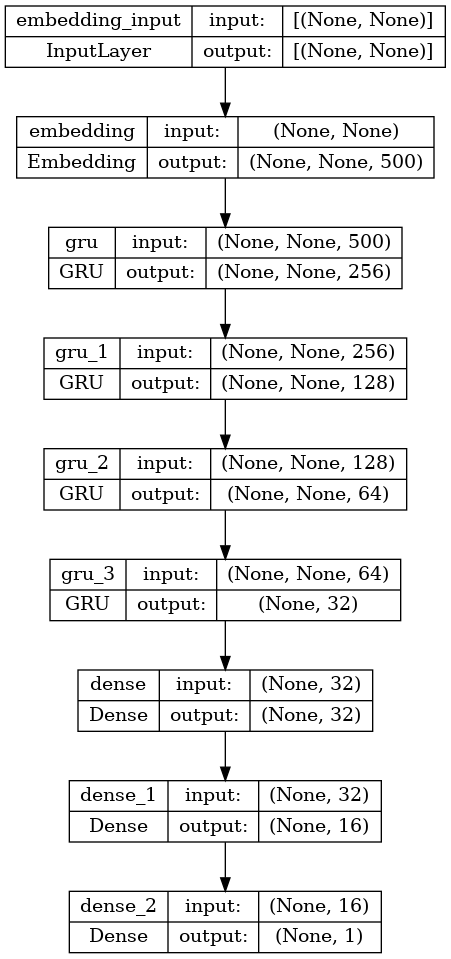

In [12]:
import keras.utils.vis_utils
from importlib import reload
reload(keras.utils.vis_utils)

from keras.utils import plot_model

plot_model(rnn, f"./output/model_nn/{FILE_NAME}_{id}_{size}_rnn_model.png", show_shapes=True)

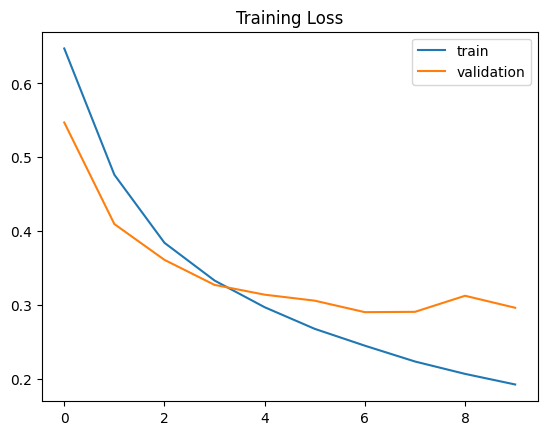

In [13]:
# Plot loss graph
import matplotlib.pyplot as plt

plt.title('Training Loss')
plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.legend(['train', 'validation'], loc='upper right')

plt.savefig(f'./output/model_nn/{FILE_NAME}_{id}_{size}_rnn_model_loss.png')

In [14]:
new_model = tf.keras.models.load_model(f'./output/model_nn/{FILE_NAME}_{id}_{size}_model.h5')

In [15]:
def predict(text):
    text_processed = process([text])
    return new_model.predict(text_processed)

In [21]:
predict("Wow iot is the best requirement")

1/1 [==============================] - 0s 22ms/step


array([[0.94850975]], dtype=float32)